# Gans

In [18]:
import torch
import torchvision#vision datasets, dataloaders
import torchvision.transforms as transforms #transformation 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [19]:
#Parameters to change
z_dim = 100
h_dim = 400
mb_size = 128
epsilon_std = 1.0
lr = 1e-3
epochs = 100
image_dim = 28
channel_dim = 1

In [20]:
#torch vision datasets are PILImages ranging from 0-1 and we want to transform them to Tensors betwwen -1 and 1
transform = transforms.Compose(#This is our transformation code, it allows us to give different transformation for images
    [transforms.ToTensor()])#transforms.Normalize((0.1307,), (0.3081,))])

#transforms.Grayscale(num_output_channels=1), 
#get our dataset, Mnist
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [21]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

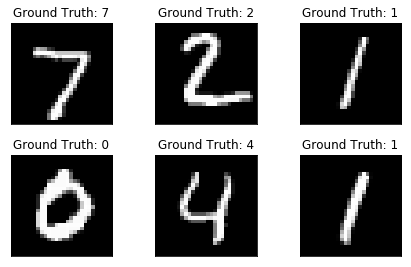

In [22]:
#Lets look at our data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [23]:
#define the generator
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, image_dim * image_dim * channel_dim)
        
    def forward(self, z):
        h = F.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(h))
        return x

In [24]:
#define the discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(image_dim * image_dim * channel_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        y = torch.sigmoid(self.fc2(h))
        return y

In [25]:
G = generator()
D = discriminator()

In [26]:
#define a loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [27]:
#Training
ones_label_s = torch.ones(mb_size, 1)
zeros_label_s = torch.zeros(mb_size, 1)

for epoch in range(epochs):  # loop over the dataset multiple times
    print("Epoch: {}".format(epoch))
    D_running_loss = 0.0
    G_running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        x, labels = data
        x = x.view(x.shape[0], -1)
        
        ones_label = ones_label_s[:len(x)]
        zeros_label = zeros_label_s[:len(x)]
        #Random noise for generator
        z = Variable(torch.randn(len(x), z_dim))
        
        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(x)
        D_fake = D(G_sample)
        D_loss_real = F.binary_cross_entropy(D_real, ones_label)#real image, and we want discriminator to learn that its a real image
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)#fake image, and we want discriminator to learn that its a fake image
        D_loss = D_loss_real + D_loss_fake
       
        D_running_loss += D_loss
        #backward
        D_loss.backward()#back prop
        #optimize
        D_optimizer.step()#perform stochastic gradient desent.
        # zero the parameter gradients
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        
        # Generator forward-loss-backward-update
        z = Variable(torch.randn(len(x), z_dim))
        G_sample = G(z)
        D_fake = D(G_sample)
        G_loss = F.binary_cross_entropy(D_fake, ones_label)
        G_running_loss += G_loss
        
        G_loss.backward()#backprop
        G_optimizer.step()#perform stochastic gradient desent.
        # zero the parameter gradients
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
    print('D_running_loss: {}'.format(D_running_loss/len(trainset)))
    print('G_running_loss: {}'.format(G_running_loss/len(trainset)))
    

Epoch: 0
D_running_loss: 0.0011086583836004138
G_running_loss: 0.04291994869709015
Epoch: 1
D_running_loss: 0.00023492191394325346
G_running_loss: 0.05187813192605972
Epoch: 2
D_running_loss: 0.00016690505435690284
G_running_loss: 0.05608069896697998
Epoch: 3
D_running_loss: 0.000142662349389866
G_running_loss: 0.05569171532988548
Epoch: 4
D_running_loss: 0.0002550045901443809
G_running_loss: 0.05565877631306648
Epoch: 5
D_running_loss: 0.0004198617534711957
G_running_loss: 0.056119561195373535
Epoch: 6
D_running_loss: 0.0005061374977231026
G_running_loss: 0.055168937891721725
Epoch: 7
D_running_loss: 0.0006498933071270585
G_running_loss: 0.051710136234760284
Epoch: 8
D_running_loss: 0.0007567536667920649
G_running_loss: 0.04862503334879875
Epoch: 9
D_running_loss: 0.0009562207269482315
G_running_loss: 0.04488762468099594
Epoch: 10
D_running_loss: 0.0011886045103892684
G_running_loss: 0.04134466126561165
Epoch: 11
D_running_loss: 0.0013892143033444881
G_running_loss: 0.0394846759736537

KeyboardInterrupt: 

In [37]:
z = Variable(torch.randn(mb_size, z_dim))
        
# Dicriminator forward-loss-backward-update
G_sample = G(z)

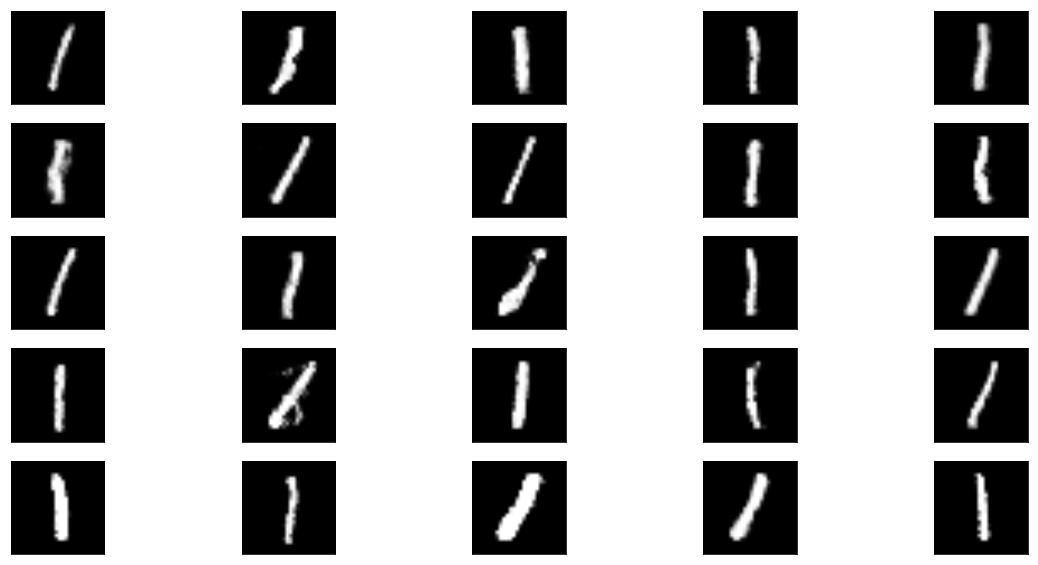

In [38]:
fig = plt.figure(figsize=(20, 10))
for i in range(25):
  plt.subplot(5,5,i+1)
  #plt.tight_layout()
  plt.imshow(G_sample[i].view(28,28).detach().numpy(), cmap='gray', interpolation='bilinear')
  plt.xticks([])
  plt.yticks([])